# Multi-Class Classification Model for [PROJECT NAME] Using Python version 15
### David Lowe
### September 15, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a predictive model using various machine learning algorithms and to document the end-to-end steps using a template. The [PROJECT NAME] dataset is a multi-class classification situation where we are trying to predict one of several (more than two) possible outcomes.

INTRODUCTION: [Sample Paragraph - The dataset involves predicting, from USA Forensic Science Service, six types of glass; defined in terms of their oxide content (i.e. Na, Fe, K, etc). The study of classification of types of glass was also partly motivated by criminological investigation. At the scene of the crime, the glass left can be used as evidence…if it is correctly identified!]

ANALYSIS: [Sample Paragraph - The average performance of the machine learning algorithms achieved an accuracy benchmark of 76.43%. Two algorithms (Extra Trees and Random Forest) produced the top accuracy metrics after the first round of modeling. After a series of tuning trials, the Random Forest model turned in a better overall result by achieving an accuracy metric of 81.43%. When configured with the optimized parameters, the Random Forest model processed the validation dataset with an accuracy score of 76.19%, which indicated potentially a high variance issue. When we applied the Random Forest model to the previously unseen test dataset, we obtained an accuracy score of 73.80%.]

CONCLUSION: [Sample Paragraph - In this iteration, the Random Forest model appeared to be a suitable algorithm for modeling this dataset. We should consider using the algorithm for further modeling.]

Dataset Used: [PROJECT NAME] Data Set

Dataset ML Model: Multi-Class classification with [numerical | categorical] attributes

Dataset Reference: [https://archive.ics.uci.edu/ml/datasets/glass+identification]

One source of potential performance benchmarks: [https://www.kaggle.com/uciml/glass]

Any predictive modeling machine learning project generally can be broken down into about six major tasks:

1. Prepare Environment
2. Summarize and Visualize Data
3. Pre-process Data
4. Train and Evaluate Models
5. Fine-tune and Improve Models
6. Finalize Model and Present Analysis

## Task 1 - Prepare Environment

In [1]:
# Install the necessary packages for Colab
# !pip install python-dotenv PyMySQL

In [2]:
# Retrieve the GPU information from Colab
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#     print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
#     print('and then re-execute this cell.')
# else:
#     print(gpu_info)

In [3]:
# Retrieve the memory configuration from Colab
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# if ram_gb < 20:
#     print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
#     print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
#     print('re-execute this cell.')
# else:
#     print('You are using a high-RAM runtime!')

In [4]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 4


### 1.a) Load libraries and modules

In [5]:
# Set the random seed number for reproducible results
seedNum = 888

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import math
import boto3
from datetime import datetime
from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
# from sklearn.pipeline import Pipeline
# from sklearn.feature_selection import RFE
# from imblearn.pipeline import Pipeline
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.combine import SMOTEENN
# from imblearn.combine import SMOTETomek

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
# from imblearn.ensemble import BalancedRandomForestClassifier
# from imblearn.ensemble import RUSBoostClassifier
# from imblearn.ensemble import BalancedBaggingClassifier

### 1.b) Set up the controlling parameters and functions

In [7]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
n_jobs = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set up the parent directory location for loading the dotenv files
useColab = False
if useColab:
    # Mount Google Drive locally for storing files
    from google.colab import drive
    drive.mount('/content/gdrive')
    gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
    env_path = '/content/gdrive/My Drive/Colab Notebooks/'
    dotenv_path = env_path + "python_script.env"
    load_dotenv(dotenv_path=dotenv_path)

# Set up the dotenv file for retrieving environment variables
useLocalPC = False
if useLocalPC:
    env_path = "/Users/david/PycharmProjects/"
    dotenv_path = env_path + "python_script.env"
    load_dotenv(dotenv_path=dotenv_path)

# Configure the plotting style
plt.style.use('seaborn')

# Set Pandas options
pd.set_option("display.max_rows", 500)
pd.set_option("display.width", 140)

# Set the percentage sizes for splitting the dataset
test_set_size = 0.2
val_set_size = 0.25

# Set the number of folds for cross validation
n_folds = 5

# Set various default modeling parameters
scoring = 'accuracy'

In [8]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [9]:
if notifyStatus: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [10]:
dataset_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data'
colNames = ['RI','Na','Mg','Al','Si','K','Ca','Ba','Fe','targetVar']
Xy_original = pd.read_csv(dataset_path, names=colNames, sep=',', header=None, index_col=0)

# Take a peek at the dataframe after import
Xy_original.head(10)

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,targetVar
1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.00,1
2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.00,1
3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.00,1
4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.00,1
5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.00,1
6,1.51596,12.79,3.61,1.62,72.97,0.64,8.07,0.0,0.26,1
7,1.51743,13.30,3.60,1.14,73.09,0.58,8.17,0.0,0.00,1
8,1.51756,13.15,3.61,1.05,73.24,0.57,8.24,0.0,0.00,1
9,1.51918,14.04,3.58,1.37,72.08,0.56,8.30,0.0,0.00,1
10,1.51755,13.00,3.60,1.36,72.99,0.57,8.40,0.0,0.11,1


In [11]:
Xy_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214 entries, 1 to 214
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   RI         214 non-null    float64
 1   Na         214 non-null    float64
 2   Mg         214 non-null    float64
 3   Al         214 non-null    float64
 4   Si         214 non-null    float64
 5   K          214 non-null    float64
 6   Ca         214 non-null    float64
 7   Ba         214 non-null    float64
 8   Fe         214 non-null    float64
 9   targetVar  214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 18.4 KB


In [12]:
Xy_original.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,targetVar
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516523,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


In [13]:
Xy_original.isnull().sum()

RI           0
Na           0
Mg           0
Al           0
Si           0
K            0
Ca           0
Ba           0
Fe           0
targetVar    0
dtype: int64

In [14]:
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

Total number of NaN in the dataframe:  0


### 1.d) Data Cleaning

In [15]:
# Standardize the class column to the name of targetVar if required
# Xy_original = Xy_original.rename(columns={'old_name': 'targetVar'})

# Dropping features
# Xy_original.drop(columns=['column1','column2','column3'], inplace=True)

# Impute missing values
# Xy_original['col_name'].fillna('someValue', inplace=True)
# Xy_original['col_name'].fillna(value=Xy_original['col_name'].median(), inplace=True)

# Convert columns from one data type to another
# Xy_original.column_name = Xy_original.column_name.astype('int')
# Xy_original.column_name = Xy_original.column_name.astype('category')

# Convert features with 1/0 levels into categorical feature of Y/N
# def reclass_somecol(code):
#     if code == 1: return 'Y'
#     else: return 'N'
# Xy_original['targetVar] = Xy_original['targetVar'].apply(reclass_somecol)

# Take a peek at the dataframe after cleaning
Xy_original.head(10)

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,targetVar
1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.00,1
2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.00,1
3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.00,1
4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.00,1
5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.00,1
6,1.51596,12.79,3.61,1.62,72.97,0.64,8.07,0.0,0.26,1
7,1.51743,13.30,3.60,1.14,73.09,0.58,8.17,0.0,0.00,1
8,1.51756,13.15,3.61,1.05,73.24,0.57,8.24,0.0,0.00,1
9,1.51918,14.04,3.58,1.37,72.08,0.56,8.30,0.0,0.00,1
10,1.51755,13.00,3.60,1.36,72.99,0.57,8.40,0.0,0.11,1


In [16]:
Xy_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214 entries, 1 to 214
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   RI         214 non-null    float64
 1   Na         214 non-null    float64
 2   Mg         214 non-null    float64
 3   Al         214 non-null    float64
 4   Si         214 non-null    float64
 5   K          214 non-null    float64
 6   Ca         214 non-null    float64
 7   Ba         214 non-null    float64
 8   Fe         214 non-null    float64
 9   targetVar  214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 18.4 KB


In [17]:
Xy_original.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,targetVar
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516523,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


In [18]:
Xy_original.isnull().sum()

RI           0
Na           0
Mg           0
Al           0
Si           0
K            0
Ca           0
Ba           0
Fe           0
targetVar    0
dtype: int64

In [19]:
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

Total number of NaN in the dataframe:  0


### 1.e) Splitting Data into Attribute-only and Target-only Sets

In [20]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = totCol

In [21]:
# We create attribute-only and target-only datasets (X_original and y_original)
# for various visualization and cleaning/transformation operations

if targetCol == totCol:
    X_original = Xy_original.iloc[:,0:totAttr]
    y_original = Xy_original.iloc[:,totAttr]
else:
    X_original = Xy_original.iloc[:,1:totCol]
    y_original = Xy_original.iloc[:,0]

print("Xy_original.shape: {} X_original.shape: {} y_original.shape: {}".format(Xy_original.shape, X_original.shape, y_original.shape))

Xy_original.shape: (214, 10) X_original.shape: (214, 9) y_original.shape: (214,)


### 1.f) Set up the parameters for data visualization

In [22]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
plt.rcParams["figure.figsize"] = fig_size

In [23]:
if notifyStatus: status_notify("Task 1 - Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [24]:
if notifyStatus: status_notify("Task 2 - Summarize and Visualize Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 2.a) Descriptive Statistics

#### 2.a.i) Peek at the attribute columns

In [25]:
X_original.head(10)

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.00
2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.00
3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.00
4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.00
5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.00
6,1.51596,12.79,3.61,1.62,72.97,0.64,8.07,0.0,0.26
7,1.51743,13.30,3.60,1.14,73.09,0.58,8.17,0.0,0.00
8,1.51756,13.15,3.61,1.05,73.24,0.57,8.24,0.0,0.00
9,1.51918,14.04,3.58,1.37,72.08,0.56,8.30,0.0,0.00
10,1.51755,13.00,3.60,1.36,72.99,0.57,8.40,0.0,0.11


#### 2.a.ii) Dimensions and attribute types

In [26]:
X_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214 entries, 1 to 214
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
dtypes: float64(9)
memory usage: 16.7 KB


#### 2.a.iii) Statistical summary of the attributes

In [27]:
X_original.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000
25%,1.516523,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000


#### 2.a.iv) Summarize the levels of the class attribute

In [28]:
Xy_original.groupby('targetVar').size()

targetVar
1    70
2    76
3    17
5    13
6     9
7    29
dtype: int64

### 2.b) Data Visualization

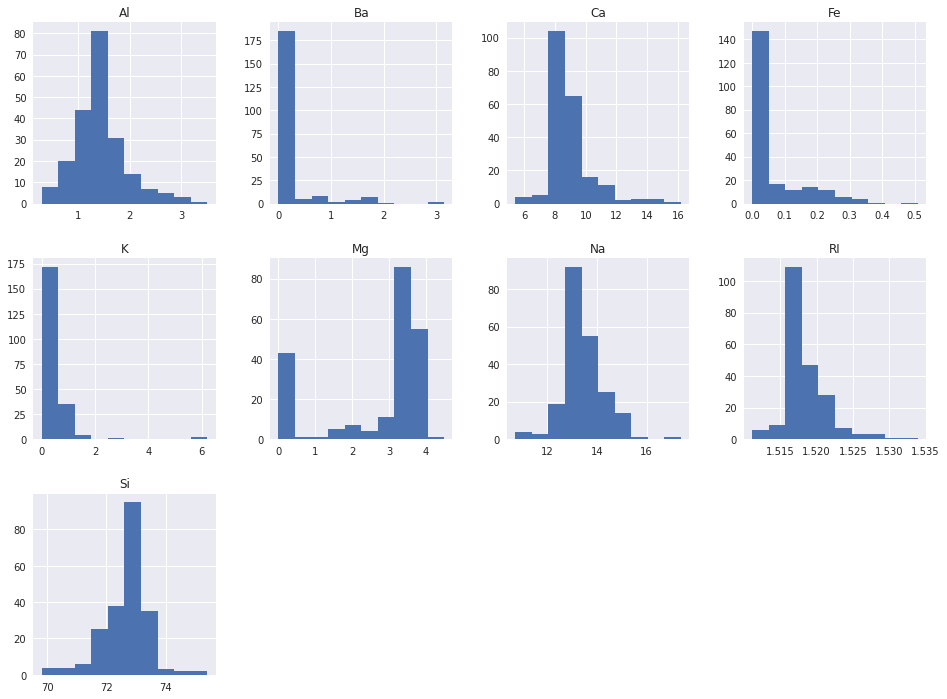

In [29]:
# Histograms for each attribute
X_original.hist(layout=(dispRow,dispCol))
plt.show()

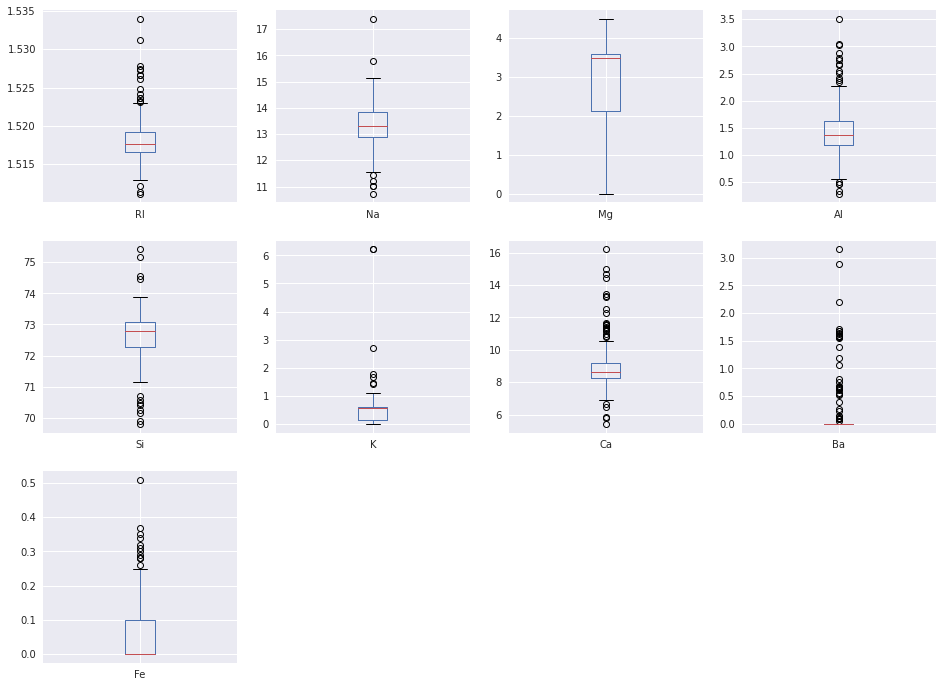

In [30]:
# Box and Whisker plot for each attribute
X_original.plot(kind='box', subplots=True, layout=(dispRow,dispCol))
plt.show()

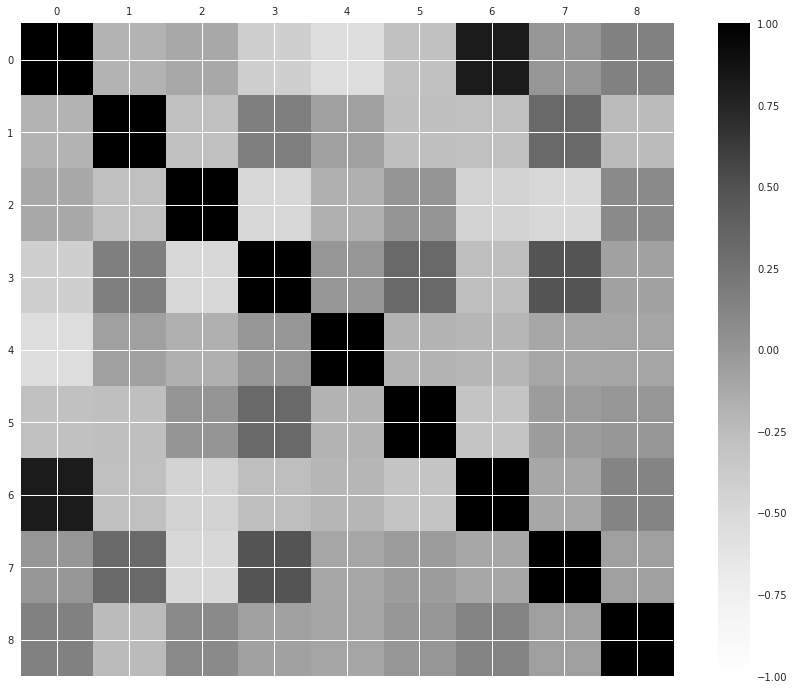

In [31]:
# Correlation matrix
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)
correlations = X_original.corr(method='pearson')
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
plt.show()

In [32]:
if notifyStatus: status_notify("Task 2 - Summarize and Visualize Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [33]:
if notifyStatus: status_notify("Task 3 - Pre-process Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Splitting Data into Training and Test Sets

In [34]:
# Not applicable for this iteration of the project
# Perform one-hot-encoding on the categorical attributes
# X_original = pd.get_dummies(X_original)
# print(X_original.info())

In [35]:
# Split the data further into training, validation, and test datasets
X_train_val, X_test_df, y_train_val, y_test_df = train_test_split(X_original, y_original, test_size=test_set_size, stratify=y_original, random_state=seedNum)
X_train_df, X_validation_df, y_train_df, y_validation_df = train_test_split(X_train_val, y_train_val, test_size=val_set_size, stratify=y_train_val, random_state=seedNum)
print("X_train_df.shape: {} y_train_df.shape: {}".format(X_train_df.shape, y_train_df.shape))
print("X_validation_df.shape: {} y_validation_df.shape: {}".format(X_validation_df.shape, y_validation_df.shape))
print("X_test_df.shape: {} y_test_df.shape: {}".format(X_test_df.shape, y_test_df.shape))

X_train_df.shape: (128, 9) y_train_df.shape: (128,)
X_validation_df.shape: (43, 9) y_validation_df.shape: (43,)
X_test_df.shape: (43, 9) y_test_df.shape: (43,)


### 3.b) Feature Scaling and Data Pre-Processing

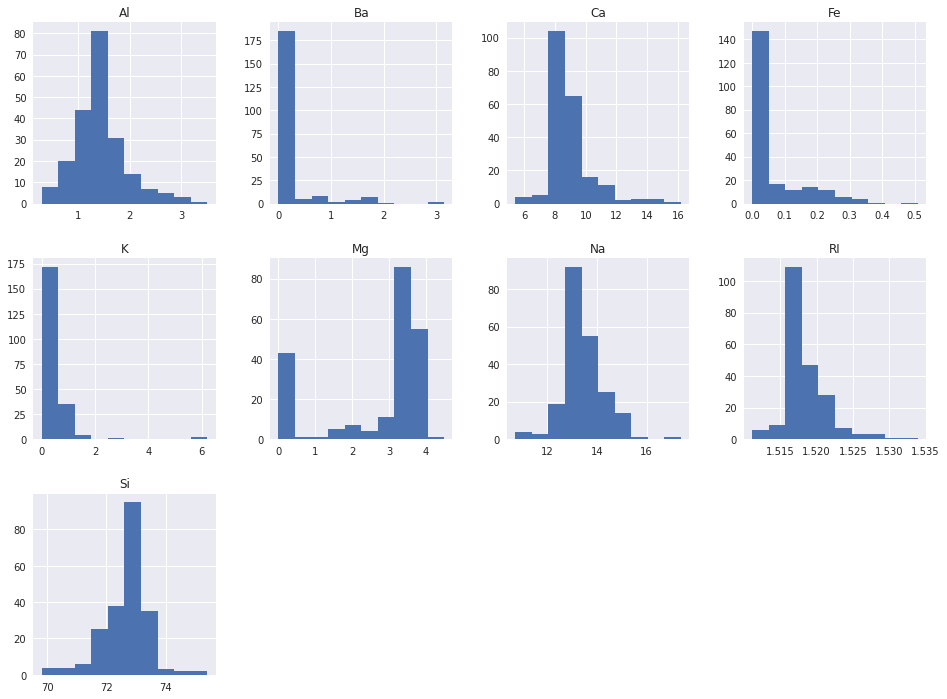

In [36]:
# Histograms for each attribute before pre-processing
columns_to_scale = X_original.columns[X_original.dtypes == 'float64'].tolist()
X_original[columns_to_scale].hist(layout=(dispRow,dispCol))
plt.show()

In [37]:
# Apply feature scaling and transformation
print('Columns to scale are:', columns_to_scale)
scaler = preprocessing.StandardScaler()
X_original[columns_to_scale] = scaler.fit_transform(X_original[columns_to_scale])
print(X_original.head())

Columns to scale are: ['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe']
         RI        Na        Mg        Al        Si         K        Ca        Ba        Fe
1  0.872868  0.284953  1.254639 -0.692442 -1.127082 -0.671705 -0.145766 -0.352877 -0.586451
2 -0.249333  0.591817  0.636168 -0.170460  0.102319 -0.026213 -0.793734 -0.352877 -0.586451
3 -0.721318  0.149933  0.601422  0.190912  0.438787 -0.164533 -0.828949 -0.352877 -0.586451
4 -0.232831 -0.242853  0.698710 -0.310994 -0.052974  0.112107 -0.519052 -0.352877 -0.586451
5 -0.312045 -0.169205  0.650066 -0.411375  0.555256  0.081369 -0.624699 -0.352877 -0.586451


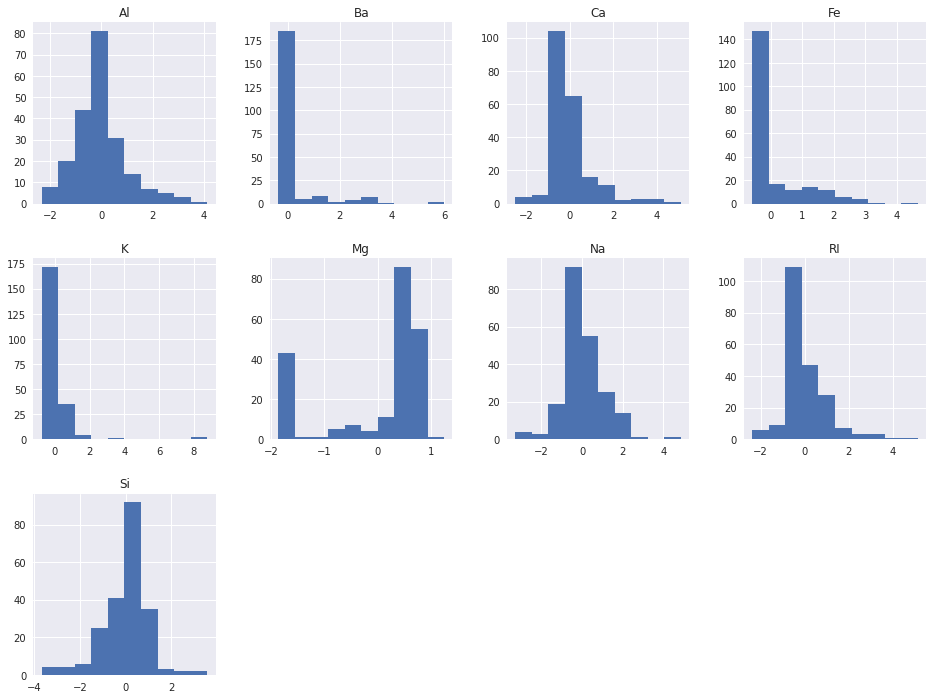

In [38]:
# Histograms for each attribute after pre-processing
X_original[columns_to_scale].hist(layout=(dispRow,dispCol))
plt.show()

In [39]:
# Apply feature scaling and transformation to the validation dataset
scaled_features = scaler.transform(X_validation_df[columns_to_scale])
X_validation_df.loc[:,tuple(columns_to_scale)] = scaled_features
print(X_validation_df.head())

           RI        Na        Mg        Al        Si         K        Ca        Ba        Fe
96   0.077425 -0.058734  0.518033 -0.029927 -0.505911  0.019893 -0.251413 -0.352877 -0.586451
186 -2.328706  0.346326  0.358204  0.732970  0.205848  1.941001 -2.484084  2.046045 -0.586451
127 -0.559589 -0.574266  0.643117 -0.371222  0.128201  0.096738 -0.251413 -0.352877 -0.586451
97   0.014714 -0.476069  0.650066 -0.772747 -0.402382  0.219689  0.121872 -0.352877  0.956588
85  -1.411142  1.033701  0.281764  1.275028 -0.480029  0.926656 -1.321968 -0.352877 -0.586451


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [40]:
# # Compose pipeline for the numerical and categorical features (Block #1 of 2)
# numeric_columns = X_train_df.select_dtypes(include=['int64','float64']).columns
# numeric_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
#     ('scaler', StandardScaler())
# ])
# categorical_columns = X_train_df.select_dtypes(include=['object','bool']).columns
# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant', fill_value='NA')),
#     ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'))
# ])

# print("Number of numerical columns:", len(numeric_columns))
# print("Number of categorical columns:", len(categorical_columns))
# print("Total number of columns in the dataframe:", X_train_df.shape[1])

In [41]:
# # Compose pipeline for the numerical and categorical features (Block #2 of 2)
# preprocessor = ColumnTransformer(transformers=[
#     ('num', numeric_transformer, numeric_columns),
#     ('cat', categorical_transformer, categorical_columns)
# ])

# # Display the shapes of the training datasets for final inspection
# X_train = preprocessor.fit_transform(X_train_df)
# y_train = y_train_df.ravel()
# print("X_train.shape: {} y_train.shape: {}".format(X_train.shape, y_train.shape))

In [42]:
# # Apply binning techniques with continuous data (Block #1 of 1)
# discrete_feature = preprocessing.Binarizer(threshold=0.0)
# discrete_feature = preprocessing.KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='kmeans')
# feature_binned = discrete_feature.fit_transform(X_original[['old_feature1']])
# X_train['new_feature1'] = feature_binned
# X_train['new_feature1'] = X_train['new_feature1'].astype('category')
# X_train.drop(columns=['old_feature1', 'old_feature2'], inplace=True)
# X_train.head()

### 3.c) Training Data Balancing

In [43]:
# Not applicable for this iteration of the project

In [44]:
# Perform SMOTE transformation on the training data (Block #1 of 2)

# X_train_imbal = X_train_df.values
# y_train_imbal = y_train_df.values.ravel()
# print("X_train_imbal.shape: {} y_train_imbal.shape: {}".format(X_train_imbal.shape, y_train_imbal.shape))

In [45]:
# Perform SMOTE transformation on the training data (Block #2 of 2)

# print ('Original class distribution - 1: {} | 0: {}'.format((y_train_imbal==1).sum(), (y_train_imbal==0).sum()))
# sm = SMOTE(random_state=seedNum, sampling_strategy=1.0)
# X_trainSmote, y_trainSmote = sm.fit_sample(X_train_imbal, y_train_imbal)
# print ('Resampled class distribution - 1: {} | 0: {}'.format((y_train==1).sum(), (y_train==0).sum()))

### 3.d) Feature Selection

In [46]:
# Not applicable for this iteration of the project

In [47]:
# Find collinear features (Block #1 of 3)

# def findCorrelated(corrmat, cutoff = 0.75):    

# ### search correlation matrix and identify pairs that if removed would reduce pair-wise correlations
# # args:
#     # corrmat: a correlation matrix
#     # cutoff: pairwise absolute correlation cutoff
# # returns:
#     # variables to removed

#     if(len(corrmat) != len(corrmat.columns)) : return 'Correlation matrix is not square'
#     averageCorr = corrmat.abs().mean(axis = 1)

#     # set lower triangle and diagonal of correlation matrix to NA
#     for row in range(0, len(corrmat)):
#         for col in range(0, (row+1)):
#             corrmat.iloc[row, col] = None

#     # where a pairwise correlation is greater than the cutoff value, check whether mean abs.corr of a or b is greater and cut it
#     to_delete = list()
#     for col in range(0, len(corrmat.columns)):
#         for row in range(0, len(corrmat)):
#             if(abs(corrmat.iloc[row, col]) > cutoff):
#                 if(averageCorr.iloc[row] > averageCorr.iloc[col]): to_delete.append(row)
#                 else: to_delete.append(col)

#     to_delete = list(set(to_delete))
#     return to_delete

In [48]:
# Find collinear features (Block #2 of 3)

# By using the calculated correlation matrix, find the collinear features
# collinear = findCorrelated(correlations, cutoff = 0.75)
# print('Number of attributes to be removed:', len(collinear))
# dropAttributes = X_train_df.columns[collinear]
# print('Columns to be removed:')
# print(dropAttributes)

In [49]:
# Find collinear features (Block #3 of 3)

# Drop the highly collinear features
# X_train_df.drop(labels=dropAttributes, axis=1, inplace=True)
# X_test_df.drop(labels=dropAttributes, axis=1, inplace=True)

In [50]:
# Perform Attribute Importance Ranking (Block #1 of 3)

# Feature Importance with Gradient Boosting Classifier
# X_impVal = X_train_df.values
# y_impVal = y_train_df.values.ravel()
# model = GradientBoostingClassifier(random_state=seedNum)
# model.fit(X_impVal, y_impVal)
# importanceScore = model.feature_importances_
# attributeList = X_train_df.columns.tolist()
# attributeImportance = pd.DataFrame({'attribute': attributeList, 'importance': importanceScore})
# rankedAttributes = attributeImportance.sort_values('importance', ascending=False)
# print(rankedAttributes)

In [51]:
# Perform Attribute Importance Ranking (Block #2 of 3)

# Set the importance threshold and calculate the list of attributes that don't contribute to the importance threshold
# importanceSum = sum(importanceScore)
# maxThreshold = 0.99
# i = 0
# accumWeight = 0
# exit_now = False
# while ((i < totAttr) and (not exit_now)) :
#     accumWeight = accumWeight + (rankedAttributes.iloc[i]['importance']/importanceSum)
#     if (accumWeight >= maxThreshold) :
#         exit_now = True
#     else :
#         i = i + 1
# print('Number of attributes contributed to the importance threshold:'+str(i))
# lowAttributes = rankedAttributes.iloc[(i):(totAttr),]['attribute'].tolist()
# print('Number of attributes found to be of low importance:',len(lowAttributes))
# print(lowAttributes)

In [52]:
# Perform Attribute Importance Ranking (Block #3 of 3)

# Removing the unselected attributes from the training and validation dataframes
# X_train_df.drop(labels=lowAttributes, axis=1, inplace=True)
# X_test_df.drop(labels=lowAttributes, axis=1, inplace=True)

In [53]:
# Perform Recursive Feature Elimination (Block #1 of 3)

# Using the ensemlbed tree algorithm, we perform the Recursive Feature Elimination (RFE) technique
# X_rfeVal = X_train_df.values
# y_rfeVal = y_train_df.values.ravel()
# estFunc = ExtraTreesClassifier(random_state=seedNum, n_jobs=cpu_num)
# strFold = StratifiedKFold(n_splits=num_folds, random_state=seedNum)
# minFeatures = 10
# selector = RFECV(estimator=estFunc, step=1, min_features_to_select= minFeatures, cv=strFold, scoring=scoring)
# selector = selector.fit(X_rfeVal, y_rfeVal)
# print('The number of selected features:',selector.n_features_)
# print('The mask of selected features:\n',selector.support_)
# print('The ranking of selected features:\n',selector.ranking_)
# plt.figure(figsize=(16,12))
# plt.xlabel("Number of features selected")
# plt.ylabel("Cross validation score")
# plt.plot(range(minFeatures, len(selector.grid_scores_) + minFeatures), selector.grid_scores_)
# plt.show()

In [54]:
# Perform Recursive Feature Elimination (Block #2 of 3)

# Remove the unselected attributes from the training dataframes
# X_train_df = X_train_df[X_train_df.columns[selector.support_]]
# print(X_train_df.shape)
# X_train_df.head()

In [55]:
# Perform Recursive Feature Elimination (Block #3 of 3)

# Remove the unselected attributes from the validation dataframes
# X_test_df = X_test_df[X_test_df.columns[selector.support_]]
# print(X_test_df.shape)
# X_test_df.head()

### 3.e) Display the Final Datasets for Model-Building

In [56]:
# Finalize the training and validation datasets for the modeling activities
X_train = X_train_df.to_numpy()
y_train = y_train_df.ravel()
X_validation = X_validation_df.to_numpy()
y_validation = y_validation_df.ravel()
print("X_train.shape: {} y_train.shape: {}".format(X_train.shape, y_train.shape))
print("X_validation.shape: {} y_validation.shape: {}".format(X_validation.shape, y_validation.shape))

X_train.shape: (128, 9) y_train.shape: (128,)
X_validation.shape: (43, 9) y_validation.shape: (43,)


In [57]:
if notifyStatus: status_notify("Task 3 - Pre-process Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Evaluate Models

In [58]:
if notifyStatus: status_notify("Task 4 - Train and Evaluate Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.a) Set test options and evaluation metric

In [59]:
# Set up Algorithms Spot-Checking Array
startTimeTraining = datetime.now()
startTimeModule = datetime.now()
train_models = []
train_results = []
train_model_names = []
train_metrics = []
train_models.append(('LDA', LinearDiscriminantAnalysis()))
train_models.append(('CART', DecisionTreeClassifier(random_state=seedNum)))
train_models.append(('KNN', KNeighborsClassifier(n_jobs=n_jobs)))
train_models.append(('BGT', BaggingClassifier(random_state=seedNum, n_jobs=n_jobs)))
train_models.append(('RNF', RandomForestClassifier(random_state=seedNum, n_jobs=n_jobs)))
train_models.append(('EXT', ExtraTreesClassifier(random_state=seedNum, n_jobs=n_jobs)))
train_models.append(('GBM', GradientBoostingClassifier(random_state=seedNum)))

In [60]:
# Generate model in turn
for name, model in train_models:
	if notifyStatus: status_notify("Algorithm "+name+" modeling has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
	startTimeModule = datetime.now()
	kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=n_jobs, verbose=1)
	train_results.append(cv_results)
	train_model_names.append(name)
	train_metrics.append(cv_results.mean())
	print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
	print(model)
	print ('Model training time:', (datetime.now() - startTimeModule), '\n')
	if notifyStatus: status_notify("Algorithm "+name+" modeling completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average metrics ('+scoring+') from all models:',np.mean(train_metrics))
print ('Total training time for all models:',(datetime.now() - startTimeTraining))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LDA: 0.655385 (0.051349)
LinearDiscriminantAnalysis()
Model training time: 0:00:00.094664 

CART: 0.640615 (0.014053)
DecisionTreeClassifier(random_state=888)
Model training time: 0:00:00.029966 

KNN: 0.695385 (0.067867)
KNeighborsClassifier(n_jobs=1)
Model training time: 0:00:00.040577 



[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


BGT: 0.688308 (0.050330)
BaggingClassifier(n_jobs=1, random_state=888)
Model training time: 0:00:00.362591 



[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RNF: 0.797231 (0.026512)
RandomForestClassifier(n_jobs=1, random_state=888)
Model training time: 0:00:02.595125 



[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


EXT: 0.804615 (0.049288)
ExtraTreesClassifier(n_jobs=1, random_state=888)
Model training time: 0:00:01.892881 

GBM: 0.719077 (0.067001)
GradientBoostingClassifier(random_state=888)
Model training time: 0:00:06.450199 

Average metrics (accuracy) from all models: 0.7143736263736262
Total training time for all models: 0:00:11.594840


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.4s finished


### 4.b) Spot-checking baseline algorithms

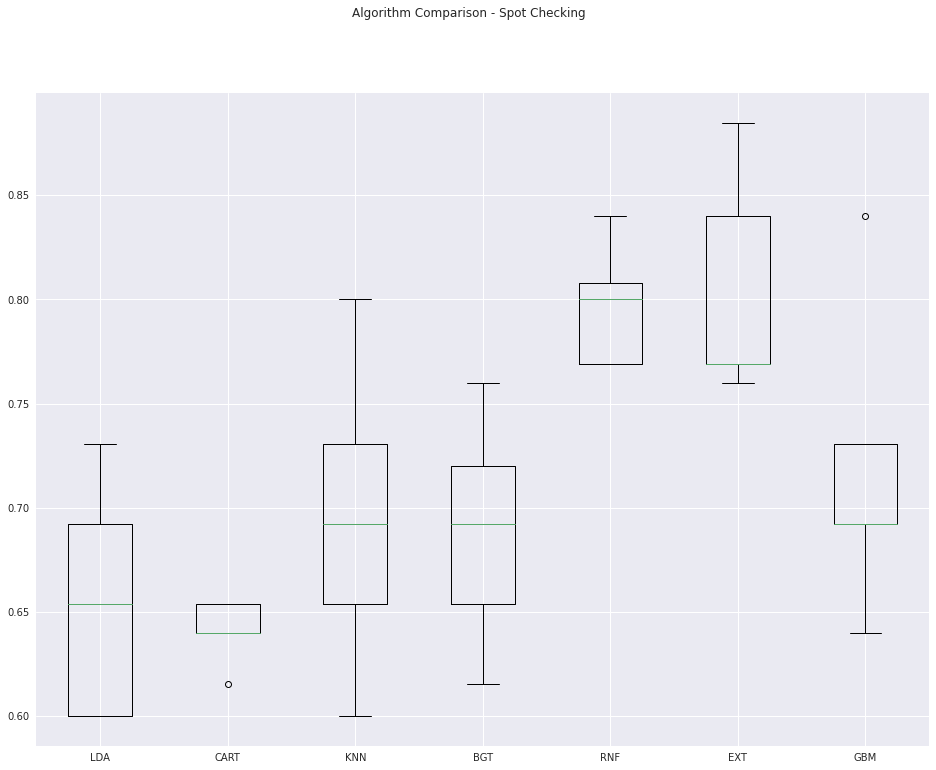

In [61]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Spot Checking')
ax = fig.add_subplot(111)
plt.boxplot(train_results)
ax.set_xticklabels(train_model_names)
plt.show()

In [62]:
if notifyStatus: status_notify("Task 4 - Train and Evaluate Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Fine-tune and Improve Models

In [63]:
if notifyStatus: status_notify("Task 5 - Fine-tune and Improve Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Algorithm Tuning

In [69]:
# Set up the comparison array
tune_results = []
tune_model_names = []

In [70]:
# Tuning algorithm #1 - Extra Trees
startTimeModule = datetime.now()
if notifyStatus: status_notify("Algorithm #1 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model1 = ExtraTreesClassifier(random_state=seedNum, n_jobs=n_jobs)
tune_model_names.append('EXT')
paramGrid1 = dict(n_estimators=np.array([10, 50, 100, 150, 200]))

kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
grid1 = GridSearchCV(estimator=tune_model1, param_grid=paramGrid1, scoring=scoring, cv=kfold, n_jobs=n_jobs, verbose=1)
grid_result1 = grid1.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
tune_results.append(grid_result1.cv_results_['mean_test_score'])
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
if notifyStatus: status_notify("Algorithm #1 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    9.9s finished


Best: 0.804615 using {'n_estimators': 100}
0.765846 (0.032902) with: {'n_estimators': 10}
0.789231 (0.016570) with: {'n_estimators': 50}
0.804615 (0.049288) with: {'n_estimators': 100}
0.804615 (0.024615) with: {'n_estimators': 150}
0.804615 (0.024615) with: {'n_estimators': 200}
Model training time: 0:00:10.299498


In [71]:
best_paramKey1 = list(grid_result1.best_params_.keys())[0]
best_paramValue1 = list(grid_result1.best_params_.values())[0]
print("Captured the best parameter for algorithm #1:", best_paramKey1, '=', best_paramValue1)

Captured the best parameter for algorithm #1: n_estimators = 100


In [72]:
# Tuning algorithm #2 - Random Forest
startTimeModule = datetime.now()
if notifyStatus: status_notify("Algorithm #2 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model2 = RandomForestClassifier(random_state=seedNum, n_jobs=n_jobs)
tune_model_names.append('RNF')
paramGrid2 = dict(n_estimators=np.array([10, 50, 100, 150, 200]))

kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
grid2 = GridSearchCV(estimator=tune_model2, param_grid=paramGrid2, scoring=scoring, cv=kfold, n_jobs=n_jobs, verbose=1)
grid_result2 = grid2.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
tune_results.append(grid_result2.cv_results_['mean_test_score'])
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
if notifyStatus: status_notify("Algorithm #2 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   13.3s finished


Best: 0.797231 using {'n_estimators': 100}
0.719385 (0.041127) with: {'n_estimators': 10}
0.766154 (0.040012) with: {'n_estimators': 50}
0.797231 (0.026512) with: {'n_estimators': 100}
0.781538 (0.038196) with: {'n_estimators': 150}
0.781538 (0.038196) with: {'n_estimators': 200}
Model training time: 0:00:13.861269


In [73]:
best_paramKey2 = list(grid_result2.best_params_.keys())[0]
best_paramValue2 = list(grid_result2.best_params_.values())[0]
print("Captured the best parameter for algorithm #2:", best_paramKey2, '=', best_paramValue2)

Captured the best parameter for algorithm #2: n_estimators = 100


### 5.b) Compare Algorithms After Tuning

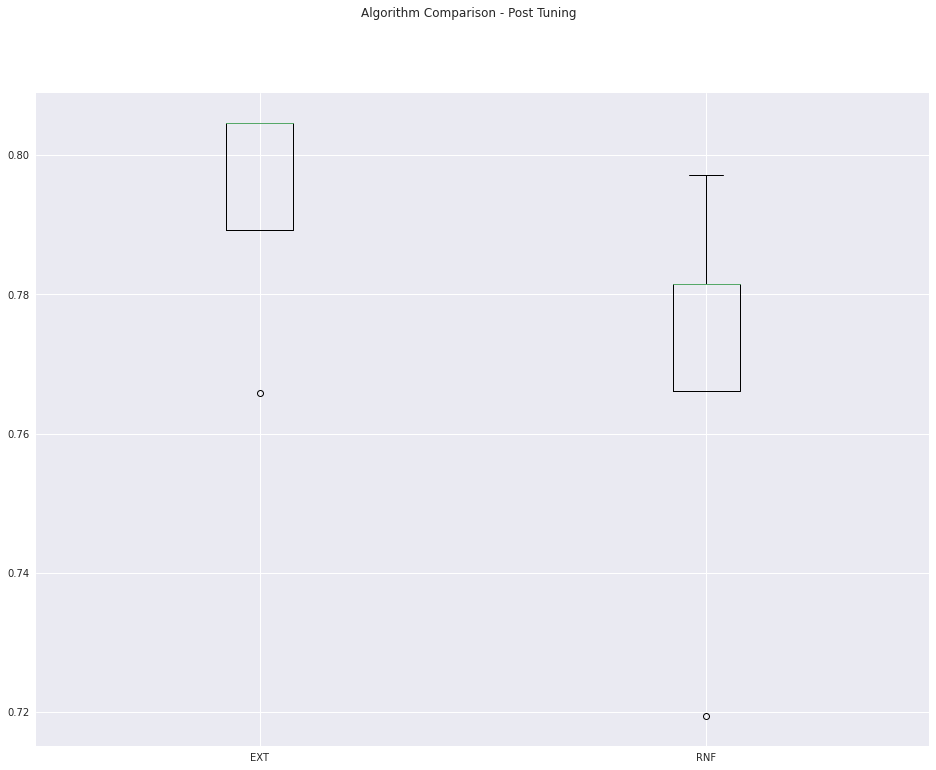

In [74]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
plt.boxplot(tune_results)
ax.set_xticklabels(tune_model_names)
plt.show()

In [68]:
if notifyStatus: status_notify("Task 5 - Fine-tune and Improve Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 6 - Finalize Model and Present Analysis

In [69]:
if notifyStatus: status_notify("Task 6 - Finalize Model and Present Analysis has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 6.a) Validate the models using the validation dataset

In [70]:
validation_model1 = ExtraTreesClassifier(n_estimators=best_paramValue1, random_state=seedNum, n_jobs=n_jobs)
validation_model1.fit(X_train, y_train)
predictions1 = validation_model1.predict(X_validation)
print('Accuracy Score:', accuracy_score(y_validation, predictions1))
print(confusion_matrix(y_validation, predictions1))
print(classification_report(y_validation, predictions1))
print(validation_model1)

Accuracy Score: 0.7407407407407407
[[12  5  1  0  0  0]
 [ 2 15  0  2  0  0]
 [ 1  0  3  0  0  0]
 [ 0  1  0  1  0  1]
 [ 0  0  0  0  2  0]
 [ 0  0  0  0  1  7]]
              precision    recall  f1-score   support

           1       0.80      0.67      0.73        18
           2       0.71      0.79      0.75        19
           3       0.75      0.75      0.75         4
           5       0.33      0.33      0.33         3
           6       0.67      1.00      0.80         2
           7       0.88      0.88      0.88         8

    accuracy                           0.74        54
   macro avg       0.69      0.74      0.71        54
weighted avg       0.75      0.74      0.74        54

BaggingClassifier(n_jobs=1, random_state=888)


In [71]:
validation_model2 = RandomForestClassifier(n_estimators=best_paramValue2, random_state=seedNum, n_jobs=n_jobs)
validation_model2.fit(X_train, y_train)
predictions2 = validation_model2.predict(X_validation)
print('Accuracy Score:', accuracy_score(y_validation, predictions2))
print(confusion_matrix(y_validation, predictions2))
print(classification_report(y_validation, predictions2))
print(validation_model2)

Accuracy Score: 0.7592592592592593
[[13  5  0  0  0  0]
 [ 0 17  0  2  0  0]
 [ 3  0  1  0  0  0]
 [ 0  1  0  1  0  1]
 [ 0  0  0  0  2  0]
 [ 0  1  0  0  0  7]]
              precision    recall  f1-score   support

           1       0.81      0.72      0.76        18
           2       0.71      0.89      0.79        19
           3       1.00      0.25      0.40         4
           5       0.33      0.33      0.33         3
           6       1.00      1.00      1.00         2
           7       0.88      0.88      0.88         8

    accuracy                           0.76        54
   macro avg       0.79      0.68      0.69        54
weighted avg       0.78      0.76      0.75        54

RandomForestClassifier(n_estimators=50, n_jobs=1, random_state=888)


### 6.b) Create a test model using all available data

In [72]:
# Combining the training and validation datasets to form the complete dataset that will be used for training the final model
X_complete = np.vstack((X_train, X_validation))
y_complete = np.concatenate((y_train, y_validation))
print("X_complete.shape: {} y_complete.shape: {}".format(X_complete.shape, y_complete.shape))
test_model = validation_model2.fit(X_complete, y_complete)
print(test_model)

### 6.c) Load test dataset and measure predictions

In [73]:
# Apply feature scaling and transformation to the test dataset
scaled_features = scaler.transform(X_test_df[columns_to_scale])
X_test_df.loc[:,tuple(columns_to_scale)] = scaled_features
print(X_test_df.head())

In [ ]:
# Finalize the test dataset for the modeling testing
X_test = X_test_df.to_numpy()
y_test = y_test_df.ravel()
print("X_test.shape: {} y_test.shape: {}".format(X_test.shape, y_test.shape))

In [ ]:
test_predictions = test_model.predict(X_test)
print('Accuracy Score:', accuracy_score(y_test, test_predictions))
print('ROC/AUC Score:', roc_auc_score(y_test, test_predictions))
print(confusion_matrix(y_test, test_predictions))
print(classification_report(y_test, test_predictions))

In [74]:
if notifyStatus: status_notify("Task 6 - Finalize Model and Present Analysis completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [75]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:01:00.270400
